## Identify hand-drawn digits prototype v2

### Imports

In [8]:
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Hyperparameters and datasets

In [9]:
INPUT_SIZE: int = 28 * 28
CLASS_CNT: int = 10
TRAIN_BATCH_SZ: int = 16
TEST_BATCH_SZ: int = 1000
EPOCHS: int = 1
LEARN_RATE = 0.01

torch.manual_seed(0x10f2c)

transformation = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)

training_set: datasets.MNIST = datasets.MNIST(
    root= "./data",
    train= True,
    download= True,
    transform= transformation
)

test_set: datasets.MNIST = datasets.MNIST(
    root= "./data",
    train= False,
    download= True,
    transform= transformation
)

train_load: DataLoader = DataLoader(
    dataset= training_set,
    batch_size= TRAIN_BATCH_SZ,
    shuffle= True
)

test_load: DataLoader = DataLoader(
    dataset= test_set,
    batch_size= TEST_BATCH_SZ,
    shuffle= False
)

device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Demo Training Data

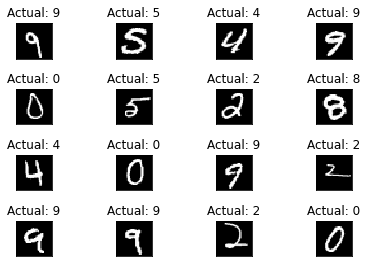

In [10]:
load_enumerate = enumerate(train_load)
idx, (demo_data, demo_target) = next(load_enumerate)

fig: plt.figure = plt.figure()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    plt.imshow(demo_data[i][0], cmap= "gray", interpolation= "none")
    plt.title(f"Actual: {demo_target[i]}")
    plt.xticks([])
    plt.yticks([])


### Model Definition

In [11]:
class Digitv2Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(
            in_channels= 1,
            out_channels= 5,
            kernel_size= 3,
            padding= "same",
            padding_mode= "zeros",
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size= 2,
            stride= 2,
        )
        self.conv2 = nn.Conv2d(
            in_channels= 5,
            out_channels= 10,
            kernel_size= 3,
            padding= "same",
            padding_mode= "zeros",
        )
        self.pool2 = nn.MaxPool2d(
            kernel_size= 2,
            stride= 2,
        )
        self.l1 = nn.Linear(10 * 7 * 7, 30)
        self.l2 = nn.Linear(30, 10)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 490)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

model = Digitv2Network().to(device)
print(model)

Digitv2Network(
  (relu): ReLU()
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=490, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)


### Training the model

In [12]:
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: torch.optim.SGD = torch.optim.SGD(model.parameters(), lr= LEARN_RATE)

n_steps = len(train_load)

for epoch in range(EPOCHS):
    for i, (img, label) in enumerate(train_load):
        img = img.to(device)
        label = label.to(device)

        # forward pass
        output = model(img)
        loss: torch.Tensor = criterion(output, label)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % TRAIN_BATCH_SZ == 0:
            print(f"Epoch {epoch + 1}/{EPOCHS}, step {i + 1}/{n_steps}, loss = {loss.item():.4f}")

Epoch 1/1, step 16/3750, loss = 2.2915
Epoch 1/1, step 32/3750, loss = 2.3141
Epoch 1/1, step 48/3750, loss = 2.3293
Epoch 1/1, step 64/3750, loss = 2.2668
Epoch 1/1, step 80/3750, loss = 2.2585
Epoch 1/1, step 96/3750, loss = 2.3266
Epoch 1/1, step 112/3750, loss = 2.2865
Epoch 1/1, step 128/3750, loss = 2.3172
Epoch 1/1, step 144/3750, loss = 2.2394
Epoch 1/1, step 160/3750, loss = 2.2759
Epoch 1/1, step 176/3750, loss = 2.3022
Epoch 1/1, step 192/3750, loss = 2.2649
Epoch 1/1, step 208/3750, loss = 2.2834
Epoch 1/1, step 224/3750, loss = 2.2795
Epoch 1/1, step 240/3750, loss = 2.2674
Epoch 1/1, step 256/3750, loss = 2.2928
Epoch 1/1, step 272/3750, loss = 2.2737
Epoch 1/1, step 288/3750, loss = 2.2833
Epoch 1/1, step 304/3750, loss = 2.2521
Epoch 1/1, step 320/3750, loss = 2.2387
Epoch 1/1, step 336/3750, loss = 2.2513
Epoch 1/1, step 352/3750, loss = 2.2185
Epoch 1/1, step 368/3750, loss = 2.2293
Epoch 1/1, step 384/3750, loss = 2.2216
Epoch 1/1, step 400/3750, loss = 2.1950
Epoch 

### Testing the model

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for img, label in test_load:
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        _, prediction = torch.max(output, 1)
        total += label.size(0)
        correct += (prediction == label).sum().item()

    acc = 100.0 * correct / total
    print(f"Accuracy: {acc}%")

Accuracy: 95.79%


### Save

In [14]:
torch.save(model.state_dict, "./digitsv2.pth")